# Final Project
#### Advanced Data Analytics and Applications

Team 4


Last revision: 11/18/2022

**Update:**

- 11/14: Priminary models are built and embedding with Word2Vec.
- 11/15: tunning building training process
- 11/17: Building the models.
- 11/18: training on testing set

**Domain 2: Medical Text Domain**
Using a medical text library split into training and test, perform the following activities:

**Checklist:**

1. Verify the 5 categories as described in the dataset are applicable
2. Build a robust multi-category classifier to predict the 5 categories based on the training dataset (Naive-Bayes, Neural Networks, ML, Fasttext)

3. Evaluate performance on the test dataset

4. Do one of the following:
  1. Build a language model on the dataset using Fasttext or Word2Vec
  2. Use BM25 indexing to make the abstracts searchable
  3. Use topic modeling to identify themes beyond the 5 classes.
  4. Use spaCy to create an inventory of Named Entities for each abstract and  then use those to create a multi-label classifier





In [2]:
import spacy
import pandas as pd
import numpy as np
import sklearn
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
#from gensim.summarization.bm25 import BM25
from rank_bm25 import BM25
from gensim.models.fasttext import FastText
import gensim.downloader as api

from pprint import pprint

from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import log_loss, accuracy_score, classification_report, f1_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline,Pipeline


%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import os

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import keras

from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import Tokenizer
#from keras import pad_sequences
from keras.models import Sequential, Model 
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Embedding, Concatenate
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras import layers

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

nlp = spacy.load('en_core_web_md')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cpw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cpw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cpw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\cpw\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#Task 1 Verify Labels
1.1 Verify the 5 categories as described in the dataset are applicable

Proposed Labels - unverified
1. neoplasm
2. digestive
3. nervous system
4. cardiovascular
5. general

## Download & Store data

In [3]:
#Seperation of labels and text data
labels = []
texts = []
with open("data/train.dat", "r") as f:
     train_data = f.readlines() 

for line in train_data:
    splitline = line.split('\t')
    labels.append(splitline[0])
    texts.append(splitline[1])

f.close()
train_df = pd.DataFrame(   data = {'label': labels,
                                    'desc': texts   })

In [4]:
#Find desc with multiple-label
train_df['multi-label'] = 0
train_df.loc[train_df.duplicated('desc',keep=False),'multi-label'] = 1
train_df['multi-label'].value_counts()

#6140 rows with more than 1 label

0    8298
1    6140
Name: multi-label, dtype: int64

In [5]:
duplicate = train_df[train_df['multi-label']==1]
duplicate = duplicate.groupby(duplicate.desc.tolist()).size().reset_index().rename(columns={0:'number'})
duplicate['number'].value_counts()

# 2653 row has 2 labels
# 270 rows has 3 labels
# 6 rows has 4 labels

2    2653
3     270
4       6
Name: number, dtype: int64

In [6]:
# Identify unique desciption

train_df['unique'] = 0
train_df.loc[ (train_df.duplicated('desc')==False),'unique']= 1
train_df['unique'].sum()

11227

In [7]:
#Raise some examples: 
msg = duplicate.iloc[49]['index']

for i in train_df[train_df['desc']==msg].index:
  print('Index:', str(i))
  print('label:', train_df['label'][i])
  print(train_df['desc'][i][:300])
  print('\n')
    


Index: 10057
label: 2
A pilot study of suramin in the treatment of metastatic renal cell carcinoma. Suramin sodium is an aromatic polysulfonated compound that was originally introduced as an antiparasitic agent in the 1920s. Recently, in view of its ability to bind and disrupt the function of multiple growth factors and 


Index: 10120
label: 1
A pilot study of suramin in the treatment of metastatic renal cell carcinoma. Suramin sodium is an aromatic polysulfonated compound that was originally introduced as an antiparasitic agent in the 1920s. Recently, in view of its ability to bind and disrupt the function of multiple growth factors and 


Index: 12075
label: 3
A pilot study of suramin in the treatment of metastatic renal cell carcinoma. Suramin sodium is an aromatic polysulfonated compound that was originally introduced as an antiparasitic agent in the 1920s. Recently, in view of its ability to bind and disrupt the function of multiple growth factors and 


Index: 13327
label: 5
A p

In [8]:
#Prepare for mult-label classificaiton dataframe 

multi_df = train_df.copy()
multi_df['label'] = multi_df['label'].astype(int)-1

for i in range(0,5):
  multi_df[str(i)] = [1 if x == i else 0 for x in multi_df['label'] ]

multi_df = multi_df.groupby('desc').sum().reset_index().drop(['label','multi-label','unique'],axis=1)

multi_df.head(5)  #noted that the 5th row has both label 0 and 2

,desc,0,1,2,3,4
0,"""Cloggology"" revisited: endoscopic or surgical...",0,0,0,0,1
1,"""Frontal lobe"" utilization behavior associated...",0,0,1,0,0
2,"""Healed"" experimental gastric ulcers remain hi...",0,1,0,0,0
3,"""Mini-perforation"" of the colon--not all postp...",0,1,0,0,0
4,"""Moustache"" appearance in craniopharyngiomas: ...",1,0,1,0,0


## Start with Multi-category Classification Process

In [9]:
#preprocess all label 1-5 > 0-4
train_df['label'] = train_df['label'].astype(int)-1


In [10]:
train_df['label'].value_counts().sort_index()
#_ imbalance dataset


0    3163
1    1494
2    1925
3    3051
4    4805
Name: label, dtype: int64

In [11]:
dz_dict = {
  0 : 'Oncology',
  1 : 'Gastroenterology',
  2 : 'Neural disease',
  3 : 'Cardiovascular',
  4 : 'General'}

train_df['label_desc'] =train_df['label'].map(dz_dict)

<AxesSubplot: xlabel='label_desc', ylabel='count'>

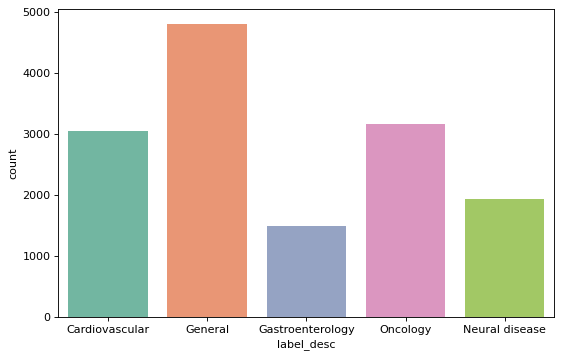

In [12]:
#distribution
plt.figure(figsize=(8, 5), dpi=80)
sns.countplot(x = train_df['label_desc'] ,palette='Set2')

In [13]:
def preprocess(text):
	stop_words = set(stopwords.words('english'))

	# Steps:
	# 1. lowercase
	# 2. Lammetize. (It does not stem. Try to preserve structure not to overwrap with potential acronym).
	# 3. Remove stop words.
	# 4. Remove punctuations.
	# 5. Remove character with the length size of 1.

	lowered = str.lower(text)
	word_tokens = word_tokenize(lowered)

	words = []
	for w in word_tokens:
		if w not in stop_words: 
			if w not in string.punctuation:
				if w not in ['``',"''",'--']:
					if len(w) > 1:
						lemmatized = lemmatizer.lemmatize(w)
						words.append(lemmatized)

	return words

In [14]:
#Step 1. manual review samples

for i in sorted(train_df['label'].unique()):
  print(f'Class: ' + train_df[train_df['label']==i].head(1)['label_desc'].values)
  pprint(str(i) + ' : ' + train_df[train_df['label']==i].iloc[:3]['desc'].values, width=200, compact = True)
  
# 1:  2/3 correct (1 general)
# 2:  3/3 correct
# 3:  3/3 correct
# 4:  3/3 correct
# 5:  1/3 correct (1 cardiovascular, 1 neoplasm)

# As we can see, the label of class 5 (general) is very unreliable

['Class: Oncology']
array(['0 : Infection during chronic epidural catheterization: diagnosis and treatment. A potentially serious complication of long-term epidural catheterization in cancer patients is infection. The early signs of infection were studied in 350 patients in whom long-term epidural catheters were inserted. Three areas of the catheter track were found to be involved; exit site and superficial catheter track infection, and epidural space infection. The authors identified the early signs of infection in each area and the progress of the infection from the deep track to include the epidural space in four of these patients. All 19 patients who developed deep track or epidural infections were successfully treated with antibiotics and catheter removal. None of the patients required surgery for spinal cord decompression. Catheters were replaced in 15 of the 19 treated patients who requested them after treatment with no recurrent infections. It was concluded that use of long-ter

In [15]:
#Sanity check again for group 5 

for i in range(0,8):
  pprint(str(i)+ ' : ' + train_df[train_df['label']==4].iloc[i]['desc'][:500], width=100, compact=True)


# 1- Renal abscess in children - ID / General
# 2- Subclavian artery to innominate vein fistula - Cardiovascular [Wrong Label]
# 3- Mediastinal tracheostomy for esophageal cancer - Cancer [Wrong Label]
# 4- idiopathic fibroinflammatory - Derm / General
# 5- asthma  - Pulm / General
# 6- automatic implantable cardioverter defibrillator - cardiovascuar [Wrong label]
# 7- stress-related mucosal damage - GI [Wrong Label]
# 8- HSV  - ID / General 

# 4/8  ~ 50% with incorrect label 

('0 : Renal abscess in children. Three cases of renal abscesses in children are described to '
 'illustrate the variable presenting features. An additional 23 pediatric cases, reported over the '
 'past ten years, were reviewed for clinical features and therapy. Fever, loin pain, and '
 'leukocytosis were common presenting features, but less than half of all abscesses were '
 'associated with either an abnormal urinalysis or a positive urine culture. The presenting '
 'features were sometimes confused with appendicitis, ')
('1 : Subclavian artery to innominate vein fistula after insertion of a hemodialysis catheter. '
 'Insertion of hemodialysis catheters for temporary use is now preferentially performed by '
 'percutaneous infraclavicular subclavian vein catheterization. This method involves passage of a '
 'stiff dilator and a peel-away sheath over a guide wire, and is usually carried out without '
 'fluoroscopy. For the most part this has proved to be a valuable and safe approach. H

## Pre-Process

In [16]:
# https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
# Classification

In [17]:
train_df['token'] = train_df['desc'].apply(lambda x: preprocess(x))
train_df['clean'] = [' '.join(x) for x in train_df['token']]
train_df.head()

,label,desc,multi-label,unique,label_desc,token,clean
0,3,Catheterization laboratory events and hospital...,1,1,Cardiovascular,"[catheterization, laboratory, event, hospital,...",catheterization laboratory event hospital outc...
1,4,Renal abscess in children. Three cases of rena...,0,1,General,"[renal, abscess, child, three, case, renal, ab...",renal abscess child three case renal abscess c...
2,1,Hyperplastic polyps seen at sigmoidoscopy are ...,1,1,Gastroenterology,"[hyperplastic, polyp, seen, sigmoidoscopy, mar...",hyperplastic polyp seen sigmoidoscopy marker a...
3,4,Subclavian artery to innominate vein fistula a...,0,1,General,"[subclavian, artery, innominate, vein, fistula...",subclavian artery innominate vein fistula inse...
4,3,Effect of local inhibition of gamma-aminobutyr...,1,1,Cardiovascular,"[effect, local, inhibition, gamma-aminobutyric...",effect local inhibition gamma-aminobutyric aci...


In [18]:
multi_df['token'] = multi_df['desc'].apply(lambda x: preprocess(x))
multi_df['clean'] = [' '.join(x) for x in multi_df['token']]

multi_df.head()

,desc,0,1,2,3,4,token,clean
0,"""Cloggology"" revisited: endoscopic or surgical...",0,0,0,0,1,"[cloggology, revisited, endoscopic, surgical, ...",cloggology revisited endoscopic surgical decom...
1,"""Frontal lobe"" utilization behavior associated...",0,0,1,0,0,"[frontal, lobe, utilization, behavior, associa...",frontal lobe utilization behavior associated p...
2,"""Healed"" experimental gastric ulcers remain hi...",0,1,0,0,0,"[healed, experimental, gastric, ulcer, remain,...",healed experimental gastric ulcer remain histo...
3,"""Mini-perforation"" of the colon--not all postp...",0,1,0,0,0,"[mini-perforation, colon, postpolypectomy, per...",mini-perforation colon postpolypectomy perfora...
4,"""Moustache"" appearance in craniopharyngiomas: ...",1,0,1,0,0,"[moustache, appearance, craniopharyngiomas, un...",moustache appearance craniopharyngiomas unique...


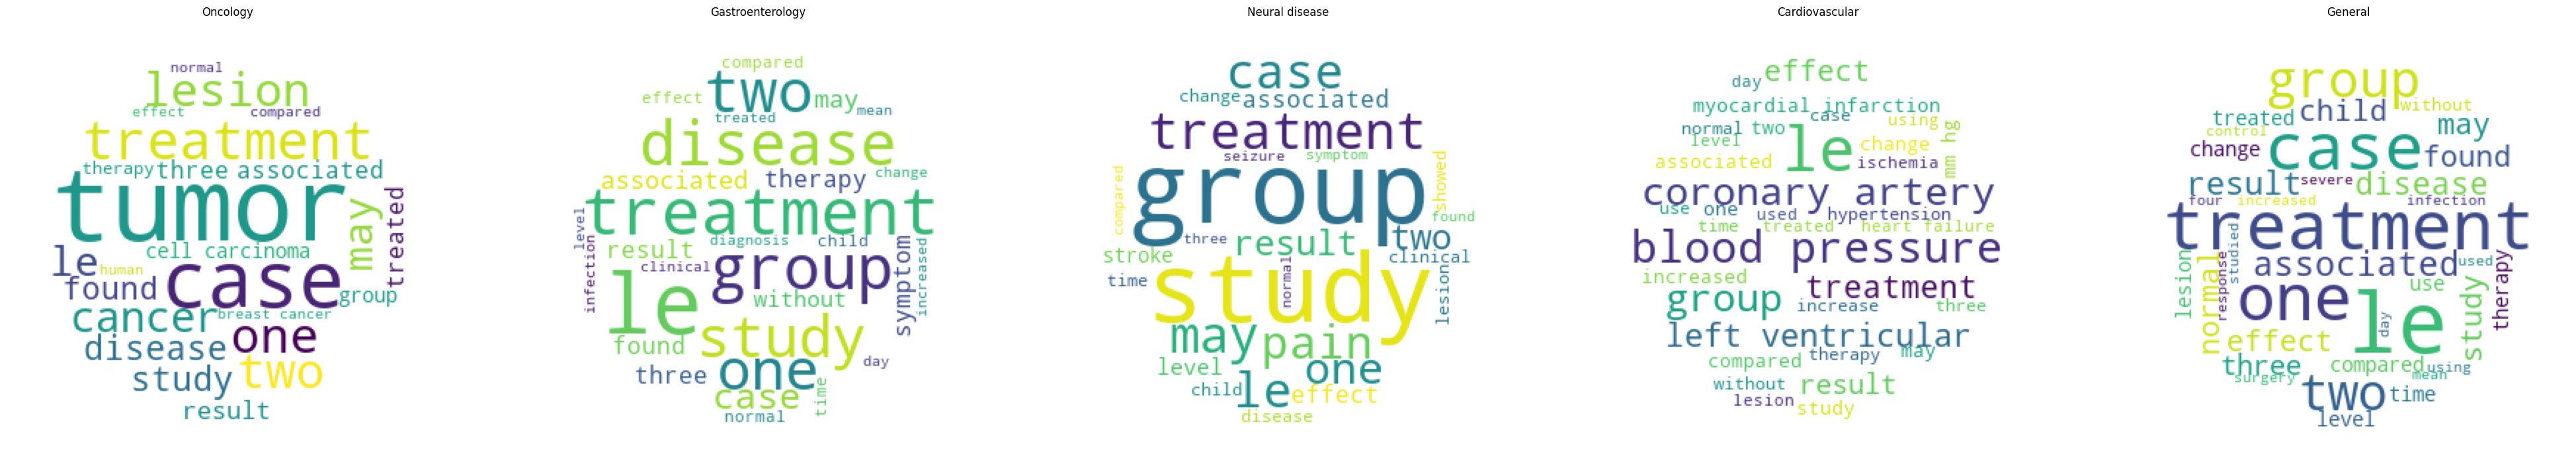

In [19]:
from PIL import Image
import re
import requests
from wordcloud import WordCloud
#wordcloud visulization

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

fig=plt.figure(figsize=(50,15))
columns = 5
for i in range(0, 5):
    fig.add_subplot(1, columns, i+1, title=f'{dz_dict[i]}')
    cloudwords = ' '.join(train_df[train_df['label']==i]['clean'])
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', mask = mask,
                min_font_size = 10).generate(re.sub('patient','',cloudwords))
    plt.axis('off')
    plt.imshow(wordcloud)

plt.show()

# Just by looking at the world-cloud, Oncology and cardiology have many high frequency words specific to that group
# e.g., Tumor -> Cancer ;  Coronary artery -> Cardiovascular disease
# Ths word cloud also make us worry about the prediction accuracy in GI & General as they are very generic words 

#Task 4: BM25 for search 

In [20]:
#utility Adapted from class 4
from IPython.display import display, Markdown, HTML

def get_top_n(bm25, query, n=5):
    
    # score docs
    #scores = np.array(bm25.get_scores(query,1))
    scores = np.array(bm25.get_scores(query))
    # get indices of top N scores
    idx = np.argpartition(scores, -n)[-n:]
    
    # sort top N scores and return their indices
    return idx[np.argsort(-scores[idx])]

def mark(s, color='black'):
      return "<text style=color:{}>{}</text>".format(color, s)

def highlight(keywords, tokens, color='SteelBlue'):
    kw_set = set(keywords)
    tokens_hl = []
    
    for t in tokens:
        if t in kw_set:
            tokens_hl.append('<b>'+mark(t, color=color)+'</b>')
        else:
            tokens_hl.append(t)
    
    return " ".join(tokens_hl)

def color_label(labels):
  color = {
        0: 'Olive', #Cancer
        1: 'Gold', #GI
        2: 'SlateBlue', #Blu
        3: 'DeepPink', #CV
        4: 'SlateGray' #general
    }
  label_token = []
  for i in labels:    
    label_token.append(mark(dz_dict[i], color[i]))  
  return display(HTML('<h3>Label:' + ', '.join(label_token)))

In [21]:
from rank_bm25 import BM25Okapi

bm25 = BM25Okapi(multi_df['token'])

In [22]:
test_query = ["cardiac"]

top_idx = get_top_n(bm25, test_query)

for n,i in enumerate(top_idx):
  labels = [x for x in multi_df.iloc[i][1:6]]
  label = [idx for (idx,x) in enumerate(labels) if x ==1]

  display(HTML('<h3>Rank: '+str(n+1)+' Index:'+str(i) + '</h3>' ))
  color_label(label)
  
  display(HTML(highlight(test_query,
                 multi_df.iloc[i].token
                )))
  display(HTML('<br/>'))

# Task 2 Build the Model
Build a robust multi-category classifier to predict the 5 categories based on the training dataset (Naive-Bayes, Neural Networks, ML, Fasttext)

In [23]:
#Set up for model training  70/30 split
X = train_df['token']
y = train_df['label']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state = 42,
                                                    stratify = train_df.label.values #imbalance dataset
                                                    )

train_df['data_type'] = 0
train_df.loc[x_train.index,'data_type'] = 'train'
train_df.loc[x_test.index,'data_type'] = 'test'
train_df.head()

,label,desc,multi-label,unique,label_desc,token,clean,data_type
0,3,Catheterization laboratory events and hospital...,1,1,Cardiovascular,"[catheterization, laboratory, event, hospital,...",catheterization laboratory event hospital outc...,train
1,4,Renal abscess in children. Three cases of rena...,0,1,General,"[renal, abscess, child, three, case, renal, ab...",renal abscess child three case renal abscess c...,test
2,1,Hyperplastic polyps seen at sigmoidoscopy are ...,1,1,Gastroenterology,"[hyperplastic, polyp, seen, sigmoidoscopy, mar...",hyperplastic polyp seen sigmoidoscopy marker a...,test
3,4,Subclavian artery to innominate vein fistula a...,0,1,General,"[subclavian, artery, innominate, vein, fistula...",subclavian artery innominate vein fistula inse...,train
4,3,Effect of local inhibition of gamma-aminobutyr...,1,1,Cardiovascular,"[effect, local, inhibition, gamma-aminobutyric...",effect local inhibition gamma-aminobutyric aci...,test


Check the vocabulary between training dataset and pre_trained model

https://www.kaggle.com/code/alhalimi/tokenization-and-word-embedding-compatibility


In [24]:
def eval_model(X, y, model, probas = None):

    if probas == 1:            
      probas = cross_val_predict(model, X, y, cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42), 
                                  n_jobs=-1, method='predict_proba', verbose=2)
    else: 
      try:
        probas = model.predict_proba(X)
      except:
        probas = model.model.predict(X)

    eval_auc(y, probas)
    #print('ovr AUC: {}'.format(roc_auc_score(y, probas, multi_class = 'ovr')))
    #print('ovo AUC: {}'.format(roc_auc_score(y, probas, multi_class = 'ovo')))
    
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]

    print('Accuracy: {}\n'.format(accuracy_score(y, preds)))
    skplt.metrics.plot_confusion_matrix(y, preds)
    print(classification_report(y, preds))


def eval_auc(y, probas):
  roc_auc_ovr = []
  classes = list(set(y))
  print('--------')
  for i in range(len(classes)):
    c = classes[i]

    y_auc = y.copy()
    y_auc = [1 if x == c else 0 for x in y_auc]
    y_probas = probas[:,i]
    roc_auc_ovr.append(roc_auc_score(y_auc, y_probas))
    print(f'class {i} AUC OvR: {roc_auc_ovr[i]:.3f}')

  print(f'Avg AUC OvR {np.mean(roc_auc_ovr):.3f}')
  print('--------')
  return roc_auc_ovr


def evaluate_features(X, y, model = LogisticRegression()):
  
    #scaler 
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
   
    eval_model(X, y, model, probas = 1)


## TFIDF

In [25]:
#Tfidf

count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

tfidf = count_vectorizer.fit_transform(train_df['desc'])

len(count_vectorizer.get_feature_names())

C:\Users\cpw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


54612

In [26]:
tfidf_mean = np.mean(tfidf)

In [27]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


--------
class 0 AUC OvR: 0.912
class 1 AUC OvR: 0.879
class 2 AUC OvR: 0.851
class 3 AUC OvR: 0.899
class 4 AUC OvR: 0.659
Avg AUC OvR 0.840
--------
Accuracy: 0.5581798032968556

              precision    recall  f1-score   support

           0       0.73      0.67      0.70      3163
           1       0.53      0.28      0.37      1494
           2       0.52      0.34      0.41      1925
           3       0.69      0.59      0.64      3051
           4       0.45      0.64      0.52      4805

    accuracy                           0.56     14438
   macro avg       0.58      0.50      0.53     14438
weighted avg       0.58      0.56      0.56     14438



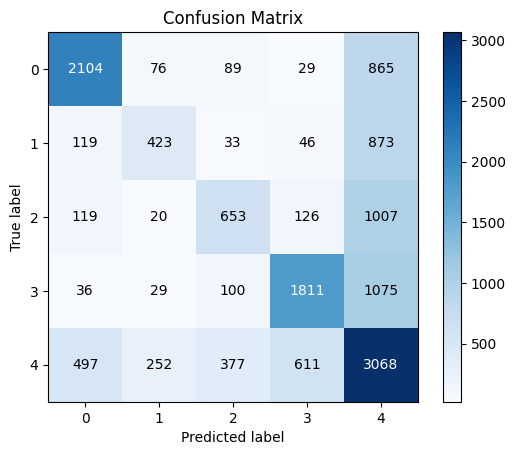

In [28]:
evaluate_features(truncated_tfidf, train_df['label'].values.ravel())

## Word2Vec

In [29]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec 
        self.dim = len(word2vec.vectors[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #X = MyTokenizer().fit_transform(X)        
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec.vocab]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [30]:
#Vectorize using pretrained model
#https://github.com/RaRe-Technologies/gensim-data

info = api.info()  # show info about available models/datasets
w2v_model = api.load("glove-wiki-gigaword-300")  # download the model and return as object ready for use

#Check Word2Vec dimension
w2v_model['word'].shape


(300,)

### Vectorization

In [31]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2v_model) #use pre-trained model from wiki
mean_embedded = mean_embedding_vectorizer.fit_transform(train_df['token'])

### Logistic regression

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


--------
class 0 AUC OvR: 0.917
class 1 AUC OvR: 0.900
class 2 AUC OvR: 0.864
class 3 AUC OvR: 0.905
class 4 AUC OvR: 0.687
Avg AUC OvR 0.855
--------
Accuracy: 0.5909405734866325

              precision    recall  f1-score   support

           0       0.71      0.74      0.72      3163
           1       0.56      0.44      0.49      1494
           2       0.54      0.44      0.48      1925
           3       0.67      0.68      0.67      3051
           4       0.50      0.55      0.52      4805

    accuracy                           0.59     14438
   macro avg       0.59      0.57      0.58     14438
weighted avg       0.59      0.59      0.59     14438



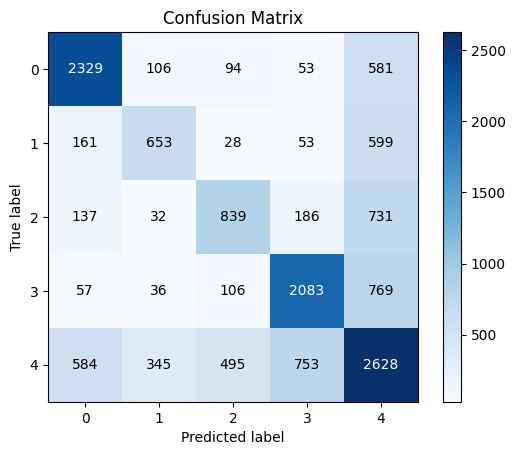

In [32]:
evaluate_features(mean_embedded, train_df['label'].values.ravel())

### Random Forest

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


--------
class 0 AUC OvR: 0.840
class 1 AUC OvR: 0.723
class 2 AUC OvR: 0.715
class 3 AUC OvR: 0.808
class 4 AUC OvR: 0.417
Avg AUC OvR 0.701
--------
Accuracy: 0.40982130488987395

              precision    recall  f1-score   support

           0       0.61      0.59      0.60      3163
           1       0.07      0.03      0.04      1494
           2       0.25      0.14      0.18      1925
           3       0.54      0.51      0.52      3051
           4       0.32      0.46      0.38      4805

    accuracy                           0.41     14438
   macro avg       0.36      0.34      0.34     14438
weighted avg       0.40      0.41      0.40     14438



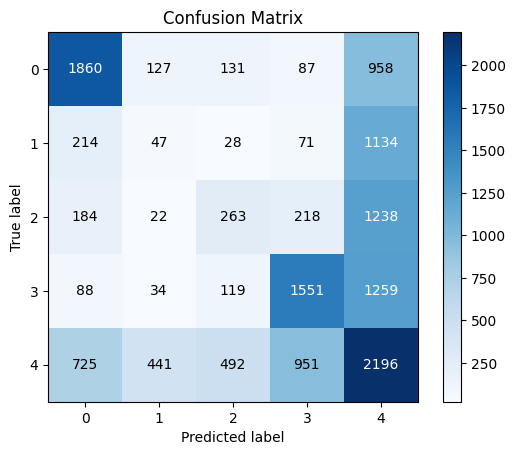

In [33]:
evaluate_features(mean_embedded, train_df['label'].values.ravel(),
                  RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1))

### LightGBM

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.3s finished


--------
class 0 AUC OvR: 0.892
class 1 AUC OvR: 0.828
class 2 AUC OvR: 0.810
class 3 AUC OvR: 0.872
class 4 AUC OvR: 0.613
Avg AUC OvR 0.803
--------
Accuracy: 0.5031860368472088

              precision    recall  f1-score   support

           0       0.67      0.66      0.67      3163
           1       0.31      0.06      0.09      1494
           2       0.47      0.16      0.24      1925
           3       0.63      0.57      0.60      3051
           4       0.40      0.64      0.49      4805

    accuracy                           0.50     14438
   macro avg       0.50      0.42      0.42     14438
weighted avg       0.51      0.50      0.48     14438



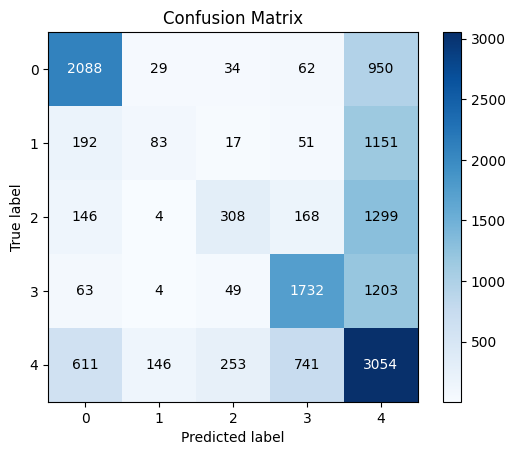

In [34]:
evaluate_features(mean_embedded, 
                  train_df['label'].values.ravel(),
                  LGBMClassifier(objective='multiclass', 
                                 learning_rate=0.01)
                 )

### Naive Bayes

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


--------
class 0 AUC OvR: 0.885
class 1 AUC OvR: 0.842
class 2 AUC OvR: 0.823
class 3 AUC OvR: 0.870
class 4 AUC OvR: 0.646
Avg AUC OvR 0.813
--------
Accuracy: 0.44050422496190605

              precision    recall  f1-score   support

           0       0.69      0.46      0.55      3163
           1       0.00      0.00      0.00      1494
           2       0.50      0.00      0.00      1925
           3       0.70      0.27      0.39      3051
           4       0.37      0.85      0.51      4805

    accuracy                           0.44     14438
   macro avg       0.45      0.32      0.29     14438
weighted avg       0.49      0.44      0.37     14438



C:\Users\cpw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cpw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cpw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedM

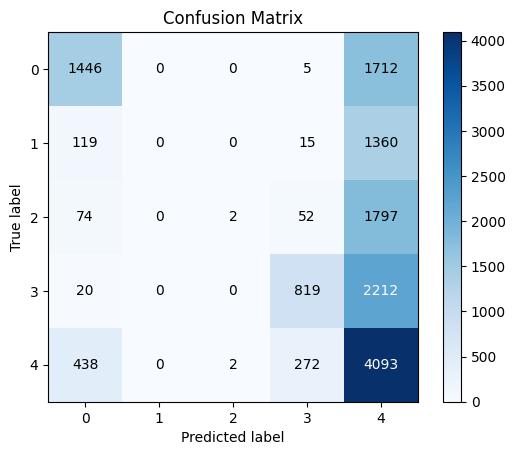

In [35]:
evaluate_features(mean_embedded, 
                  train_df['label'].values.ravel(),
                  MultinomialNB()                  
                  )

###Neural Network

In [36]:
# define baseline model
def baseline_model():
	# create model
  model = Sequential()
  model.add(Dense(128, input_dim=300, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


C:\Users\cpw\AppData\Local\Temp\ipykernel_5780\2200738367.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=5, verbose=0)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished


--------
class 0 AUC OvR: 0.918
class 1 AUC OvR: 0.888
class 2 AUC OvR: 0.843
class 3 AUC OvR: 0.903
class 4 AUC OvR: 0.671
Avg AUC OvR 0.845
--------
Accuracy: 0.584568499792215

              precision    recall  f1-score   support

           0       0.67      0.80      0.73      3163
           1       0.53      0.39      0.45      1494
           2       0.55      0.39      0.46      1925
           3       0.63      0.78      0.69      3051
           4       0.50      0.46      0.48      4805

    accuracy                           0.58     14438
   macro avg       0.57      0.56      0.56     14438
weighted avg       0.57      0.58      0.57     14438



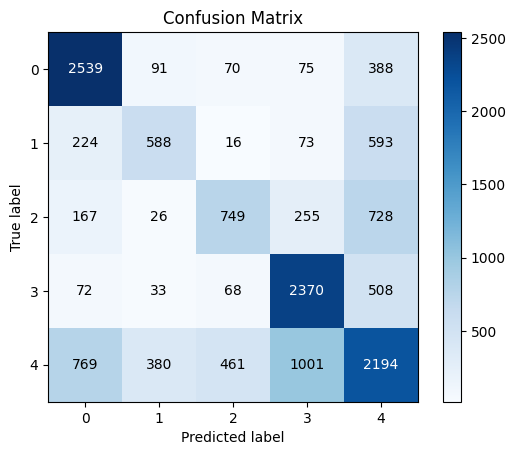

In [37]:
evaluate_features(mean_embedded, 
                  train_df['label'].values.ravel(),
                  KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=5, verbose=0)                
                  )

## FastText

In [38]:
!pip install fasttext
import fasttext

  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-win_amd64.whl size=244487 sha256=44b5b51cdf0895994370d51c5f5ec7be84615529dd460c4d2bbdf74d1b1a73c4
  Stored in directory: c:\users\cpw\appdata\local\pip\cache\wheels\3f\84\86\c63cf501c46fb575152daee4b937075a5e9b31765c0e620fd4
Successfully built fasttext


In [39]:
import os
# Prepare document 

def train_fasttext(data, x_col = 'clean', y_col = 'label' ,file = 'fast'):
  
  file_name = file + '_'   
  try:
    os.remove(file_name+'train')
    os.remove(file_name+'test')
    print('previous file deleted')
  except:
    print('no exist file')

  for x in ['train','test']:
    with open( file_name + x,'w') as f:
      for i in (data[data['data_type']==x]).index:
        f.write('__label__'+str(data[y_col][i])+' '+data[x_col][i])
        f.write('\n')
  f.close()   
  print('Complete loading file, Start training the model')   
  model =fasttext.train_supervised(input= file_name+'train', 
                                   epoch=25, 
                                   wordNgrams=2, 
                                   lr = 0.5)
  
  #evaluate the result 
  preds = []
  df = data[data['data_type']=='test']

  for i in df.index:
    preds.append(model.predict(df['clean'][i])[0][0][-1])

  print(classification_report(df['label'].astype(str), preds))
  skplt.metrics.plot_confusion_matrix(df['label'].astype(str), preds)

  return model 



no exist file
Complete loading file, Start training the model
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       949
           1       0.42      0.39      0.41       448
           2       0.44      0.37      0.40       578
           3       0.59      0.56      0.57       915
           4       0.41      0.45      0.43      1442

    accuracy                           0.50      4332
   macro avg       0.50      0.48      0.49      4332
weighted avg       0.50      0.50      0.50      4332



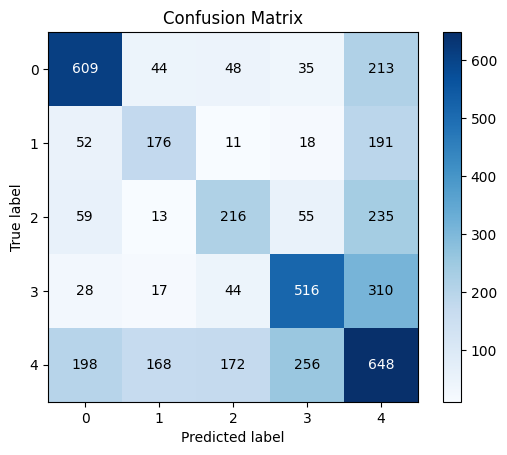

In [40]:
fasttext_model = train_fasttext(train_df)

In [41]:
#This should be classify as Cardivascular, but it is classify as General

fasttext_model.predict("Myocardial infarction is known as STEMI, require echocardiogram, this is wrong")

(('__label__4',), array([0.95631707]))

In [42]:
fasttext_model.predict("Myocardial infarction is known as STEMI, a.k.a. heart attack, require echocardiogram, this is wrong")


(('__label__3',), array([0.77816451]))

In [43]:
fasttext_model.predict("Lung cancer is one of the most lethal disease in the US")

(('__label__0',), array([0.99980813]))

In [44]:
fasttext_model.test("fast_test")

#Single label
#Precision 0.5
#Recall 0.5

(4332, 0.4997691597414589, 0.4997691597414589)

In [45]:
fasttext_model.test("fast_test", k = 2)

#Multiple label
#Precision 0.4
#Recall 0.86

(4332, 0.4325946445060018, 0.8651892890120036)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2214
           1       0.80      0.78      0.79      1046
           2       0.82      0.82      0.82      1347
           3       0.87      0.86      0.87      2136
           4       0.81      0.82      0.82      3363

    accuracy                           0.84     10106
   macro avg       0.84      0.83      0.84     10106
weighted avg       0.84      0.84      0.84     10106



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

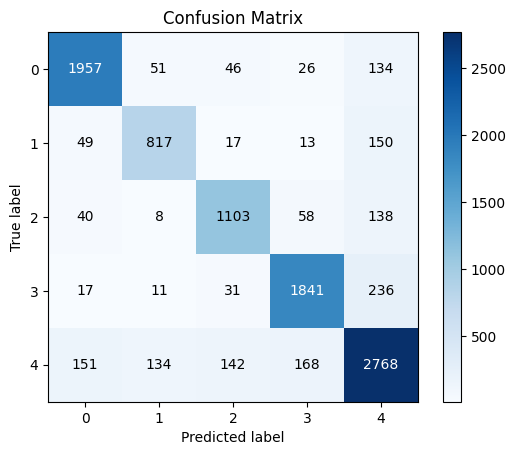

In [46]:
#Training set
preds = []
dataset = train_df[train_df['data_type']=='train']

for i in dataset.index:
  preds.append(fasttext_model.predict(train_df['clean'][i])[0][0][-1])

print(classification_report(dataset['label'].astype(str), preds))
skplt.metrics.plot_confusion_matrix(dataset['label'].astype(str), preds)


              precision    recall  f1-score   support

           0       0.64      0.64      0.64       949
           1       0.42      0.39      0.41       448
           2       0.44      0.37      0.40       578
           3       0.59      0.56      0.57       915
           4       0.41      0.45      0.43      1442

    accuracy                           0.50      4332
   macro avg       0.50      0.48      0.49      4332
weighted avg       0.50      0.50      0.50      4332



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

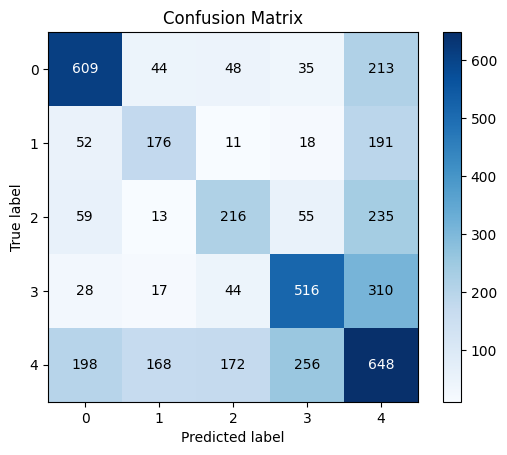

In [47]:
#Testing set
preds = []
dataset = train_df[train_df['data_type']=='test']

for i in dataset.index:
  preds.append(fasttext_model.predict(train_df['clean'][i])[0][0][-1])

print(classification_report(dataset['label'].astype(str), preds))
skplt.metrics.plot_confusion_matrix(dataset['label'].astype(str), preds)


So the result is suboptimal, how can we improve it ?

# [Method #1] Re-label class General

In above classification result, we can find that the models have difficulty to label class General. 

**Solution:**
1. Build the model without class General and evaluate the performance (LR, XGboost, FastText)
2. Attempt re-label class General



### Train model to classify 1-4

In [48]:
# dataset 2 - without label 4 - general 
train_df_2 = train_df[train_df['label']!=4]
mean_embedded_2 = mean_embedding_vectorizer.fit_transform(train_df_2['token'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


--------
class 0 AUC OvR: 0.943
class 1 AUC OvR: 0.933
class 2 AUC OvR: 0.907
class 3 AUC OvR: 0.951
Avg AUC OvR 0.934
--------
Accuracy: 0.7938336966677048

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      3163
           1       0.73      0.69      0.71      1494
           2       0.72      0.69      0.71      1925
           3       0.84      0.86      0.85      3051

    accuracy                           0.79      9633
   macro avg       0.78      0.77      0.77      9633
weighted avg       0.79      0.79      0.79      9633



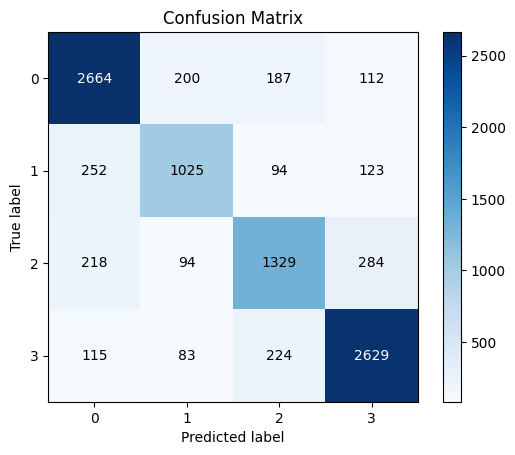

In [49]:
#LR 
evaluate_features(mean_embedded_2, train_df_2['label'].values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.3s finished


--------
class 0 AUC OvR: 0.918
class 1 AUC OvR: 0.875
class 2 AUC OvR: 0.868
class 3 AUC OvR: 0.924
Avg AUC OvR 0.896
--------
Accuracy: 0.7132772760303124

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      3163
           1       0.71      0.36      0.48      1494
           2       0.69      0.52      0.59      1925
           3       0.72      0.86      0.78      3051

    accuracy                           0.71      9633
   macro avg       0.71      0.65      0.66      9633
weighted avg       0.71      0.71      0.70      9633



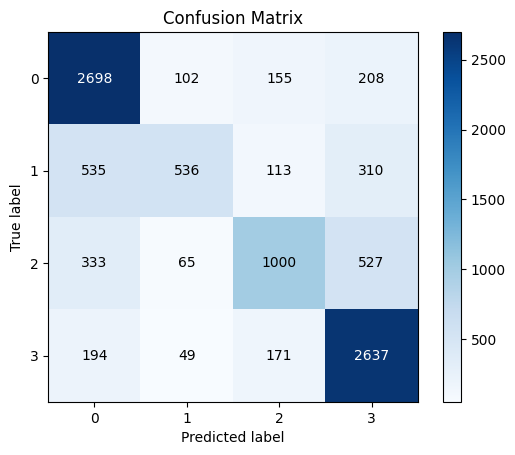

In [50]:
#ML LGB
evaluate_features(mean_embedded_2, 
                  train_df_2['label'].values.ravel(),
                  LGBMClassifier(objective='multiclass', 
                                 learning_rate=0.01)
                 )

C:\Users\cpw\AppData\Local\Temp\ipykernel_5780\2736828362.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=5, verbose=0)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished


--------
class 0 AUC OvR: 0.942
class 1 AUC OvR: 0.924
class 2 AUC OvR: 0.886
class 3 AUC OvR: 0.941
Avg AUC OvR 0.923
--------
Accuracy: 0.7704764870756774

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3163
           1       0.74      0.61      0.67      1494
           2       0.65      0.68      0.67      1925
           3       0.82      0.81      0.82      3051

    accuracy                           0.77      9633
   macro avg       0.75      0.74      0.75      9633
weighted avg       0.77      0.77      0.77      9633



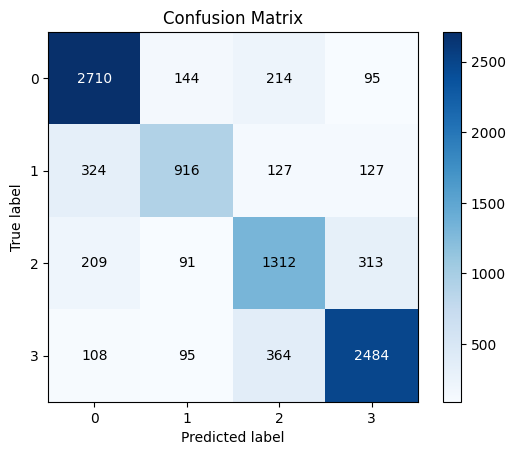

In [51]:
def baseline_model():
	# create model
  model = Sequential()
  model.add(Dense(128, input_dim=300, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(4, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

evaluate_features(mean_embedded_2, 
                  train_df_2['label'].values.ravel(),
                  KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=5, verbose=0)                
                  )

previous file deleted
Complete loading file, Start training the model
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       949
           1       0.74      0.70      0.72       448
           2       0.69      0.68      0.69       578
           3       0.82      0.85      0.84       915

    accuracy                           0.78      2890
   macro avg       0.77      0.76      0.76      2890
weighted avg       0.78      0.78      0.78      2890



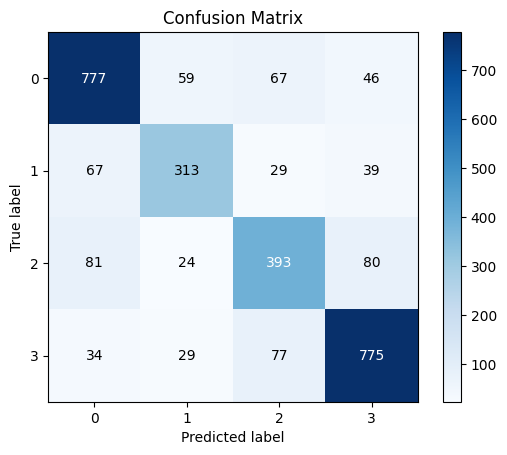

In [52]:
##Fast Text
fasttext_model_2 = train_fasttext(train_df_2)

In [53]:
#test this description from group 5
testing_msg =  train_df[train_df['label']==4]['clean'][6]
testing_msg

'mediastinal tracheostomy using pectoralis major myocutaneous flap resection carcinoma esophagus involving proximal part trachea operative procedure mediastinal tracheostomy using pectoralis major myocutaneous flap presented procedure terminal portion trachea penetrates center pectoralis major myocutaneous flap tracheal wall completely wrapped muscular portion flap 1981 1988 eight patient carcinoma cervicothoracic segment esophagus underwent mediastinal tracheostomy laryngoesophagectomy extended resection proximal part trachea sternal manubrectomy invasion trachea five eight patient pectoralis major myocutaneous flap used construct tracheal stoma skin flap skin flap muscle flap used three four eight patient tracheal necrosis occurred rupture brachiocephalic artery occurred one patient tracheal stoma constructed using skin flap muscle flap however neither skin breakdown bleeding major vessel occurred using myocutaneous flap therefore concluded construction tracheal stoma using pectorali

In [54]:
#This is indeed cancer 
fasttext_model_2.predict(testing_msg) 

(('__label__0',), array([0.99485284]))

In [55]:
fasttext_model_2.test("fast_test")

#Single label
#Precision 0.78
#Recall 0.78

(2890, 0.7813148788927335, 0.7813148788927335)

In [56]:
fasttext_model_2.test("fast_test",k = 2)

(2890, 0.47352941176470587, 0.9470588235294117)

# [Method #2] Multi-label classification

In [57]:
multi_train, multi_test, y_train, y_test = train_test_split(  multi_df['token'], 
                                                              multi_df.drop(['desc','token','clean'],axis=1),
                                                              random_state=42, 
                                                              test_size=0.30, 
                                                              shuffle=True)

x_train = mean_embedding_vectorizer.fit_transform(multi_train)
x_test = mean_embedding_vectorizer.fit_transform(multi_test)

## Use Multiple One vs Rest Method

In [58]:
result = pd.DataFrame(columns=['accuracy','F1 score'])
result = result.append({'accuracy':'test'},ignore_index=True)
result

C:\Users\cpw\AppData\Local\Temp\ipykernel_5780\3451062356.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'accuracy':'test'},ignore_index=True)


,accuracy,F1 score
0,test,NaN


In [59]:
from sklearn.multiclass import OneVsRestClassifier
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

result = pd.DataFrame()
for category in range(0,5):

  category = str(category)
  # Training logistic regression model on train data
  LogReg_pipeline.fit(x_train, y_train[category])
  
  proba = LogReg_pipeline.predict_proba(x_test)
  prediction = LogReg_pipeline.predict(x_test)
  
  result = result.append({
      'AUC OvR' : round(roc_auc_score(y_test[category],proba[:,1]) ,3 ),
      'accuracy' : round(accuracy_score(y_test[category], prediction),3),
      'F1 score' : round(f1_score(y_test[category], prediction),3)
  },ignore_index= True)

result

C:\Users\cpw\AppData\Local\Temp\ipykernel_5780\605238866.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({
C:\Users\cpw\AppData\Local\Temp\ipykernel_5780\605238866.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({
C:\Users\cpw\AppData\Local\Temp\ipykernel_5780\605238866.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({
C:\Users\cpw\AppData\Local\Temp\ipykernel_5780\605238866.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({
C:\Users\cpw\AppData\Local\Temp\ipykernel_5780\605238866.py:17: FutureWarning: The frame.append method i

,AUC OvR,accuracy,F1 score
0,0.952,0.913,0.831
1,0.930,0.922,0.642
2,0.889,0.881,0.597
3,0.945,0.903,0.812
4,0.751,0.688,0.617


## Classifier Chain

In [60]:
!pip install scikit-multilearn

     ---------------------------------------- 89.4/89.4 kB 2.6 MB/s eta 0:00:00


In [61]:
#https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

# using classifier chains
from skmultilearn.problem_transform import ClassifierChain

# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression()).fit(x_train, y_train)
predictions = classifier.predict(x_test)

print("F1_score = ",f1_score(y_test,predictions,average='weighted'))
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

F1_score =  0.7253784704511267
Accuracy =  0.5571386168002375




C:\Users\cpw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Re-label Class 5 - General - Using fasttext

In [62]:
def fast_predict(label, desc):
  if label == 4:
    try:  #if threshold > 0.85, return new label, We intentially set it higher, so we don't over label people to other classes
      return fasttext_model_2.predict(desc, threshold= 0.85)[0][0][-1]
    except: #else return 4
      return label
  else:
    return label  

train_df['new_label'] = train_df[['label','clean']].apply(lambda x: fast_predict(x.label, x.clean), axis=1)
train_df['new_label'] = train_df['new_label'].astype(int)



In [63]:
train_df[train_df['label']==4].head(8)[['clean','label','new_label']]

#Let's go back to check if new classification is valid

# 1- Renal abscess in children - ID / General                                              - [Wrong] GI 
# 2- Subclavian artery to innominate vein fistula - Cardiovascular [Wrong Label]           - [Correct] Cardiovascular 
# 3- Mediastinal tracheostomy for esophageal cancer - Cancer [Wrong Label]                 - [Correct] Cancer 
# 4- idiopathic fibroinflammatory - Derm / General                                         - [wrong] cancer 
# 5- Asthma  - Pulm / General                                                              - [Correct] Geneneral 
# 6- automatic implantable cardioverter defibrillator - cardiovascuar [Wrong label]        - [Correct] cardiovascular 
# 7- stress-related mucosal damage - GI [Wrong Label]                                      - [Correct] GI 
# 8- HSV encephalitis - ID / General                                                       - [Correct] ID /General


# From observation, we find that FastText successfully learn the labels that we thought it was wrong, however, it also categorize some statement to other classes

,clean,label,new_label
1,renal abscess child three case renal abscess c...,4,1
3,subclavian artery innominate vein fistula inse...,4,3
6,mediastinal tracheostomy using pectoralis majo...,4,0
7,tumefactive fibroinflammatory lesion extremity...,4,0
9,increasing asthma prevalence rural new zealand...,4,4
10,usefulness automatic implantable cardioverter ...,4,3
11,stress-related mucosal damage review drug ther...,4,1
13,controlled trial comparing vidarabine acyclovi...,4,4


In [64]:
train_df['new_label'].value_counts().sort_index()

0    3880
1    2046
2    2675
3    4112
4    1725
Name: new_label, dtype: int64

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


--------
class 0 AUC OvR: 0.944
class 1 AUC OvR: 0.931
class 2 AUC OvR: 0.909
class 3 AUC OvR: 0.950
class 4 AUC OvR: 0.842
Avg AUC OvR 0.915
--------
Accuracy: 0.7428314170937803

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      3880
           1       0.71      0.69      0.70      2046
           2       0.69      0.71      0.70      2675
           3       0.81      0.86      0.84      4112
           4       0.50      0.37      0.43      1725

    accuracy                           0.74     14438
   macro avg       0.70      0.69      0.70     14438
weighted avg       0.73      0.74      0.74     14438



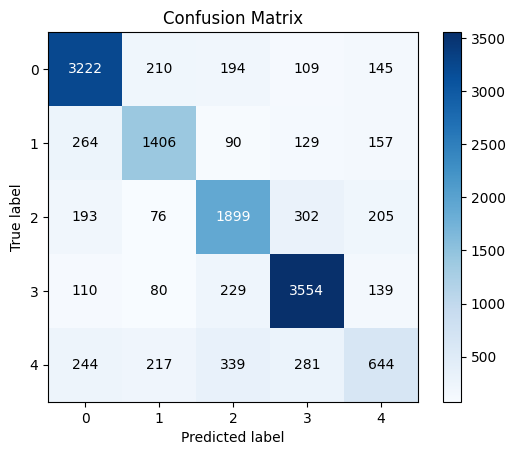

In [65]:
#Evaluate with LR to check the classification report with new label system

evaluate_features(mean_embedded, train_df['new_label'].values.ravel())


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.5s finished


--------
class 0 AUC OvR: 0.927
class 1 AUC OvR: 0.891
class 2 AUC OvR: 0.876
class 3 AUC OvR: 0.931
class 4 AUC OvR: 0.792
Avg AUC OvR 0.883
--------
Accuracy: 0.6660202244078127

              precision    recall  f1-score   support

           0       0.69      0.84      0.76      3880
           1       0.71      0.46      0.56      2046
           2       0.64      0.62      0.63      2675
           3       0.65      0.88      0.75      4112
           4       0.51      0.07      0.13      1725

    accuracy                           0.67     14438
   macro avg       0.64      0.58      0.57     14438
weighted avg       0.65      0.67      0.63     14438



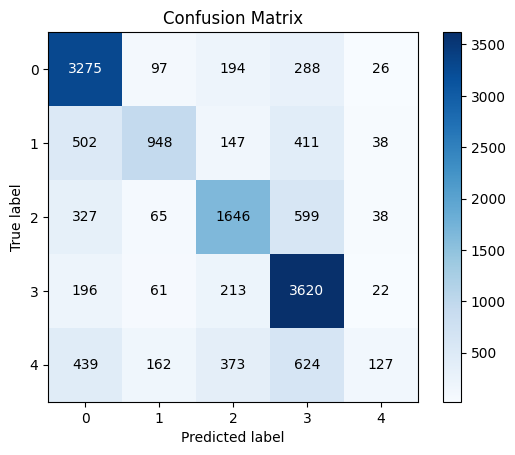

In [66]:
evaluate_features(mean_embedded, 
                  train_df['new_label'].values.ravel(),
                  LGBMClassifier(objective='multiclass', 
                                 learning_rate=0.01)
                 )

#Task 2/3 Build models and evaluate performance

In [69]:
import pickle
from gensim.test.utils import get_tmpfile

file_path = 'model/'

In [70]:
#embedding

mean_embedded_train = mean_embedding_vectorizer.fit_transform(train_df[train_df['data_type'] == 'train']['token'])
mean_embedded_test = mean_embedding_vectorizer.fit_transform(train_df[train_df['data_type'] == 'test']['token'])

y_train_new = train_df[train_df['data_type'] == 'train']['new_label']
y_test_new = train_df[train_df['data_type'] == 'test']['new_label']


### Naive Bayes


--------
class 0 AUC OvR: 0.910
class 1 AUC OvR: 0.858
class 2 AUC OvR: 0.852
class 3 AUC OvR: 0.912
class 4 AUC OvR: 0.774
Avg AUC OvR 0.861
--------
Accuracy: 0.5946445060018467

              precision    recall  f1-score   support

           0       0.80      0.68      0.73      1165
           1       0.72      0.18      0.29       623
           2       0.49      0.68      0.57       804
           3       0.82      0.70      0.76      1226
           4       0.26      0.52      0.34       514

    accuracy                           0.59      4332
   macro avg       0.62      0.55      0.54      4332
weighted avg       0.67      0.59      0.60      4332



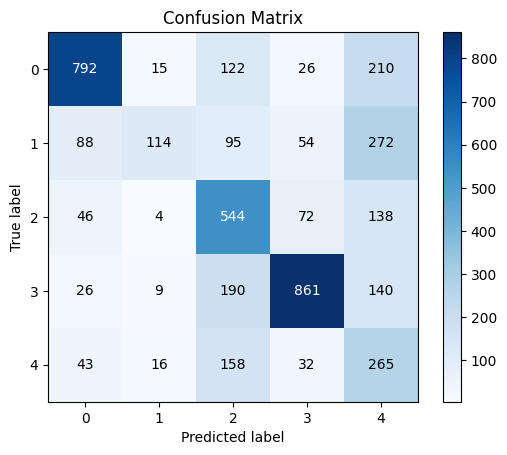

In [75]:

pipe_nb = make_pipeline(MinMaxScaler(),
                        MultinomialNB()
)

naive = pipe_nb.fit(mean_embedded_train,y_train_new)

eval_model(X = MinMaxScaler().fit_transform(mean_embedded_test),
           y = y_test_new,
           model = naive   
)

pickle.dump(naive, open(file_path+'nb.model','wb'))  #NB

### LightGBM

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min

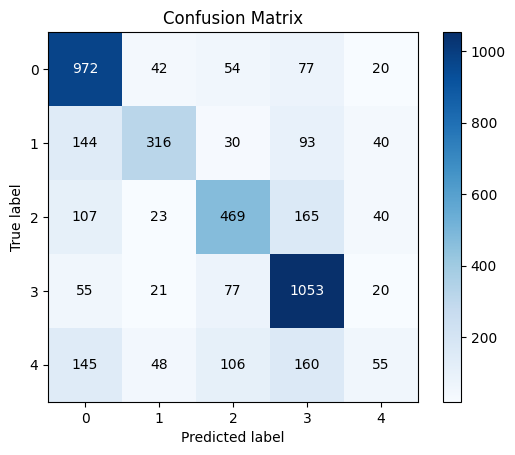

In [76]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30],
    }

lgb_estimator = LGBMClassifier(boosting_type='gbdt',  
                               objective='multiclass', 
                               learning_rate=0.01)

lgb_model = GridSearchCV(estimator=lgb_estimator, 
                        param_grid=param_grid, 
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)).fit(mean_embedded_train, y_train_new)

eval_model(mean_embedded_test,
           y_test_new,
           lgb_model.best_estimator_  
)

pickle.dump(lgb_model.best_estimator_, open(file_path+'lgbm.model','wb'))  #LGBM

### Neural Network

C:\Users\cpw\AppData\Local\Temp\ipykernel_5780\2864478793.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  NN_model = KerasClassifier(build_fn=baseline_model,


136/136 [==============================] - 0s 807us/step
--------
class 0 AUC OvR: 0.943
class 1 AUC OvR: 0.922
class 2 AUC OvR: 0.895
class 3 AUC OvR: 0.938
class 4 AUC OvR: 0.838
Avg AUC OvR 0.907
--------
Accuracy: 0.711449676823638

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1165
           1       0.69      0.66      0.67       623
           2       0.70      0.59      0.64       804
           3       0.76      0.85      0.80      1226
           4       0.42      0.47      0.44       514

    accuracy                           0.71      4332
   macro avg       0.68      0.67      0.67      4332
weighted avg       0.72      0.71      0.71      4332



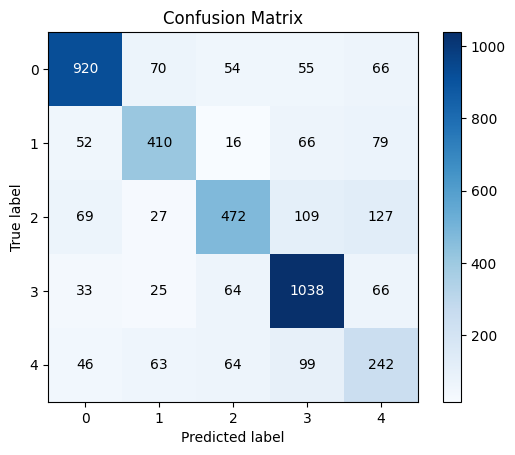

In [77]:
def baseline_model():
	# create model
  model = Sequential()
  model.add(Dense(128, input_dim=300, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


NN_model = KerasClassifier(build_fn=baseline_model, 
                           epochs=30, 
                           batch_size=10, verbose=0).fit(mean_embedded_train, y_train_new, validation_split = 0.3 )


eval_model(X = mean_embedded_test,
           y = y_test_new,
           model = NN_model   
)

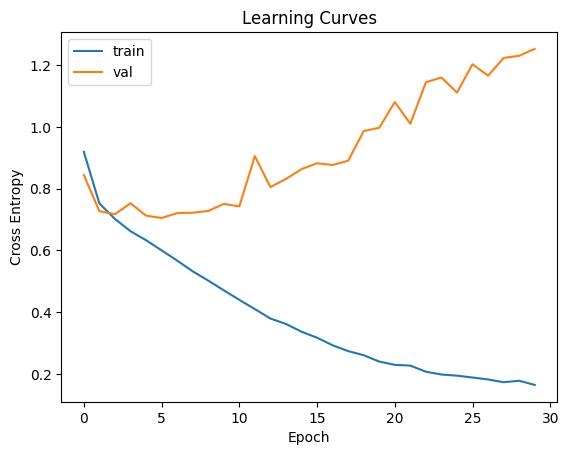

In [78]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(NN_model.history['loss'], label='train')
plt.plot(NN_model.history['val_loss'], label='val')
plt.legend()
plt.show()

#overfitting when Epoch > 3

C:\Users\cpw\AppData\Local\Temp\ipykernel_5780\499700259.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  NN_model = KerasClassifier(build_fn=baseline_model,


136/136 [==============================] - 0s 770us/step
--------
class 0 AUC OvR: 0.952
class 1 AUC OvR: 0.936
class 2 AUC OvR: 0.912
class 3 AUC OvR: 0.957
class 4 AUC OvR: 0.872
Avg AUC OvR 0.926
--------
Accuracy: 0.7433056325023084

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1165
           1       0.73      0.70      0.71       623
           2       0.70      0.69      0.69       804
           3       0.77      0.90      0.83      1226
           4       0.58      0.23      0.33       514

    accuracy                           0.74      4332
   macro avg       0.71      0.68      0.68      4332
weighted avg       0.73      0.74      0.73      4332



INFO:tensorflow:Assets written to: model/NN.model\assets


INFO:tensorflow:Assets written to: model/NN.model\assets


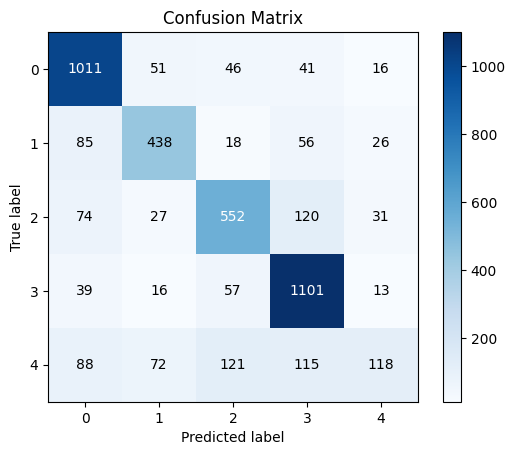

In [79]:
NN_model = KerasClassifier(build_fn=baseline_model, 
                           epochs=3, 
                           batch_size=10, verbose=0).fit(mean_embedded_train, y_train_new)


eval_model(X = mean_embedded_test,
           y = y_test_new,
           model = NN_model   
)

NN_model.model.save(file_path+'NN.model') #NN

### FastText

previous file deleted
Complete loading file, Start training the model
              precision    recall  f1-score   support

           0       0.64      0.79      0.70       949
           1       0.47      0.64      0.54       448
           2       0.44      0.60      0.51       578
           3       0.60      0.82      0.69       915
           4       0.62      0.22      0.32      1442

    accuracy                           0.56      4332
   macro avg       0.55      0.61      0.55      4332
weighted avg       0.58      0.56      0.53      4332



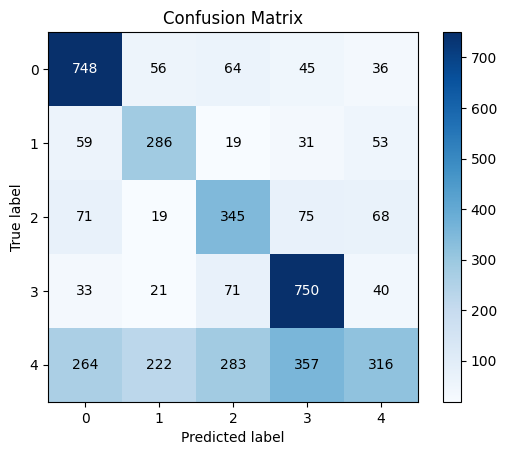

In [81]:
final_fasttext = train_fasttext(train_df, 
                                x_col = 'clean',
                                y_col = 'new_label',
                                file = 'final_fast')

In [82]:
final_fasttext.save_model(file_path+'fasttext.model') #fast_test

# Label Test Data Set


In [85]:
#Seperation of labels and text data

test_df = pd.DataFrame()

with open("data/test.dat", "r") as f:
     test_data = f.readlines()
     f.close()

test_df = pd.DataFrame( data = { 'desc': test_data   })
test_df['token'] = [preprocess(x) for x in test_df.desc]

mean_embedding_test = mean_embedding_vectorizer.fit_transform(test_df['token'])


In [86]:
def sanity_check(model):
  try: 
    test_df['label'] = np.argmax(model.predict(mean_embedding_test), axis=1)
  except:
    test_df['label'] = model.predict(mean_embedding_test)
  
  test_df['label_desc'] =test_df['label'].map(dz_dict)
  preds = test_df['label_desc']
  plt.figure(figsize=(8, 5))
  sns.countplot(x = test_df['label_desc'].sort_values())  

  print('Distribution:')
  return preds

452/452 [==============================] - 0s 838us/step
Distribution:


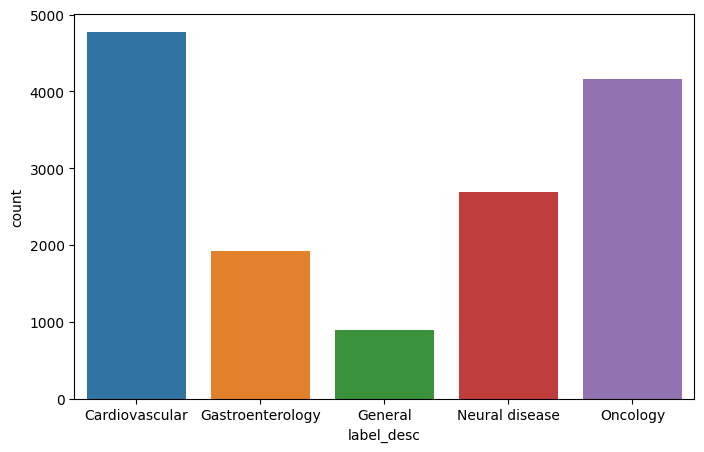

In [87]:
test_df['NN'] = sanity_check(NN_model.model)

Distribution:


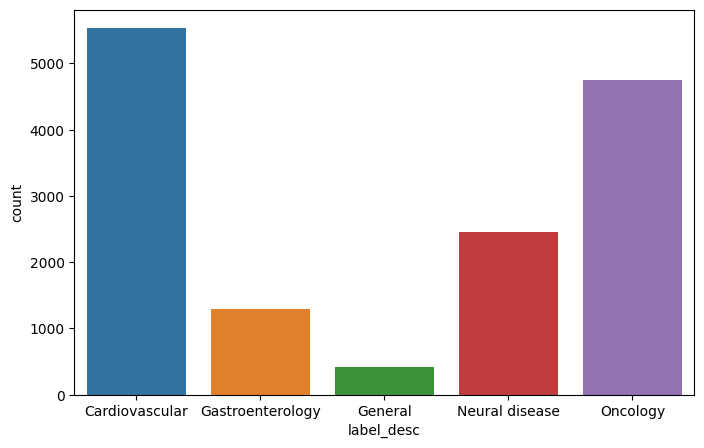

In [88]:
test_df['lgbm'] = sanity_check(model= lgb_model.best_estimator_)




Distribution:


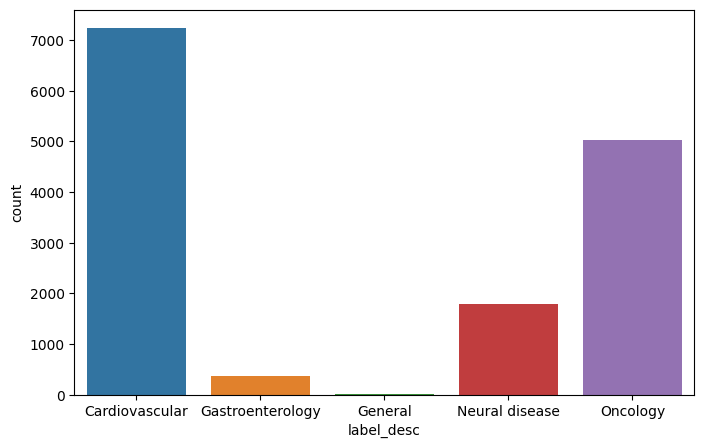

In [89]:
test_df['NB'] =sanity_check(model= naive)

<AxesSubplot: xlabel='FastText', ylabel='count'>

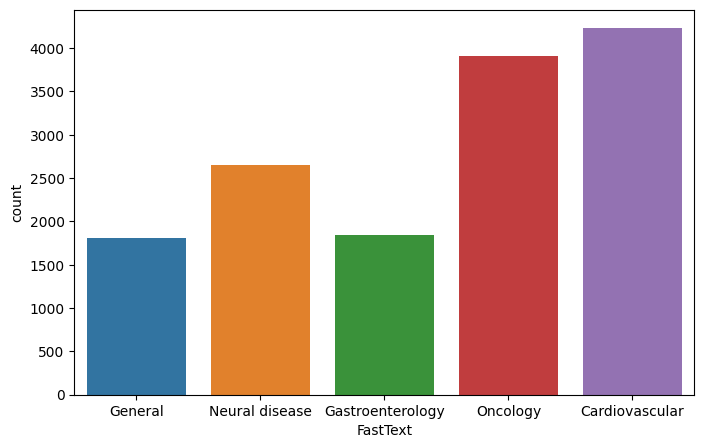

In [97]:
test_df['FastText'] = [final_fasttext.predict(' '.join(x))[0][0][-1] for x in test_df['token']]
test_df['FastText'] = test_df['FastText'].astype(int).map(dz_dict)

plt.figure(figsize=[8,5])
sns.countplot(x = test_df['FastText'])

In [98]:
test_df.head(10)

,desc,token,label,label_desc,NN,lgbm,NB,FastText
0,Excision of limbal dermoids. We reviewed the c...,"[excision, limbal, dermoids, reviewed, clinica...",3,Cardiovascular,Oncology,Neural disease,Cardiovascular,General
1,Bell's palsy. A diagnosis of exclusion. In cas...,"[bell, 's, palsy, diagnosis, exclusion, case, ...",2,Neural disease,Neural disease,Neural disease,Neural disease,Neural disease
2,Retained endobronchial foreign body removal fa...,"[retained, endobronchial, foreign, body, remov...",0,Oncology,Oncology,General,Oncology,General
3,Recurrent buccal space abscesses: a complicati...,"[recurrent, buccal, space, abscess, complicati...",1,Gastroenterology,Gastroenterology,Gastroenterology,Gastroenterology,Gastroenterology
4,Intracranial fibromatosis. Fibromatoses are un...,"[intracranial, fibromatosis, fibromatoses, unc...",0,Oncology,Oncology,Oncology,Oncology,Oncology
5,The effect of intrathecal morphine on somatose...,"[effect, intrathecal, morphine, somatosensory,...",3,Cardiovascular,Neural disease,Cardiovascular,Cardiovascular,Cardiovascular
6,The 29th Rovenstine lecture: clinical challeng...,"[29th, rovenstine, lecture, clinical, challeng...",2,Neural disease,Oncology,Cardiovascular,Neural disease,Neural disease
7,Mortality in patients treated with flecainide ...,"[mortality, patient, treated, flecainide, enca...",3,Cardiovascular,Cardiovascular,Cardiovascular,Cardiovascular,Cardiovascular
8,Approaches to immunotherapy of cancer: charact...,"[approach, immunotherapy, cancer, characteriza...",0,Oncology,Oncology,Oncology,Oncology,Oncology
9,Retinal artery obstruction and atheromas assoc...,"[retinal, artery, obstruction, atheroma, assoc...",0,Oncology,Cardiovascular,Cardiovascular,Oncology,Cardiovascular


In [99]:
#let's doublec check what's going on with index 0, 2, 5, 9

for i in [0,2,5,9]:
  print('index:',i)
  pprint(test_df.iloc[i]['desc'],width=100)
  print('\n')

#0 -- it's a dermatology case, should be general 
#2 -- It's a pulmonary case with endobronchial polyp  -- general 
#5 -- It's Neurology case (Neural network is correct, others are wrong)
#9 -- It's a retinal artery obstscrtion from lymphoma -- both Oncology and Cardiovascular are correct 


index: 0
('Excision of limbal dermoids. We reviewed the clinical files of 10 patients who had undergone '
 'excision of unilateral epibulbar limbal dermoids. Preoperatively, all of the affected eyes had '
 'worse visual acuity (P less than .02) and more astigmatism (P less than .01) than the '
 'contralateral eyes. Postoperatively, every patient was cosmetically improved. Of the eight '
 'patients for whom both preoperative and postoperative visual acuity measurements had been '
 'obtained, in six it had changed minimally (less than or equal to 1 line), and in two it had '
 'improved (less than or equal to 2 lines). Surgical complications included persistent epithelial '
 'defects (40%) and peripheral corneal vascularization and opacity (70%). These complications do '
 'not outweigh the cosmetic and visual benefits of dermoid excision in selected patients. \n')


index: 2
('Retained endobronchial foreign body removal facilitated by steroid therapy of an obstructing, '
 'inflammatory po